# MA cencus block and town join, basic geospatial EDA

### Goals:
* matching different geospatial systems/crs across files using shapefiles - join the census block and towns
* derive the x and y coordinates for each town for modeling from the shapefile (centroid)

### Outputs:
* data/tidy_data/ma_town_crs4326_coords.csv  - MA tows with centroid x/y points for modeling
* data/tidy_data/census_block_town_match.csv

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_data = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2014_to_2018.csv")
# census blocks map
census_blocks = gpd.read_file("../../data/raw_data/shapefiles_and_geography_related/CENSUS2010_BLK_BG_TRCT_SHP/CENSUS2010BLOCKGROUPS_POLY.shp")
town_map = gpd.read_file("../../data/raw_data/shapefiles_and_geography_related/townssurvey_shp/TOWNSSURVEY_POLYM.shp")

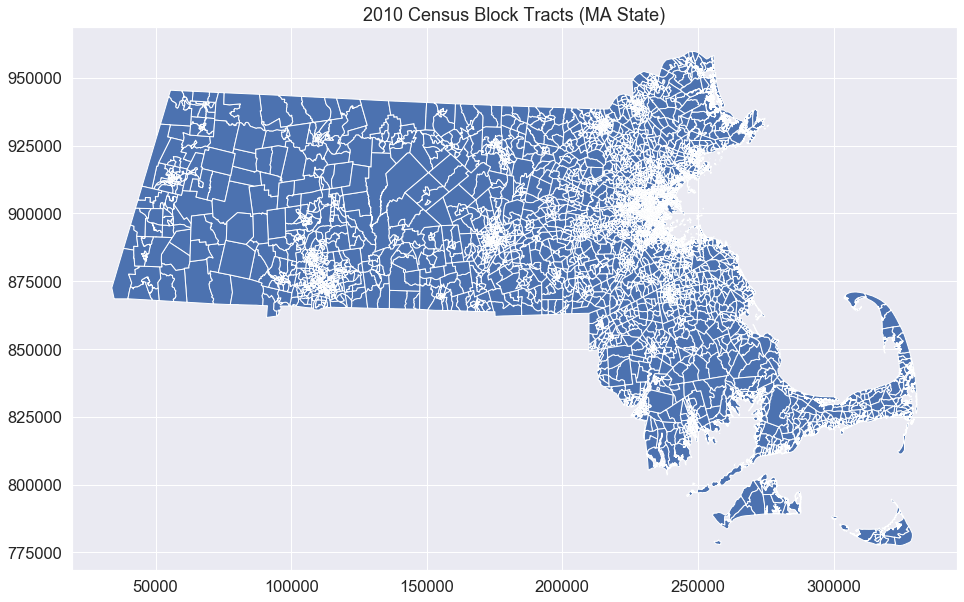

In [3]:
census_blocks.plot(figsize=(16,10))
plt.title("2010 Census Block Tracts (MA State)")
plt.show()

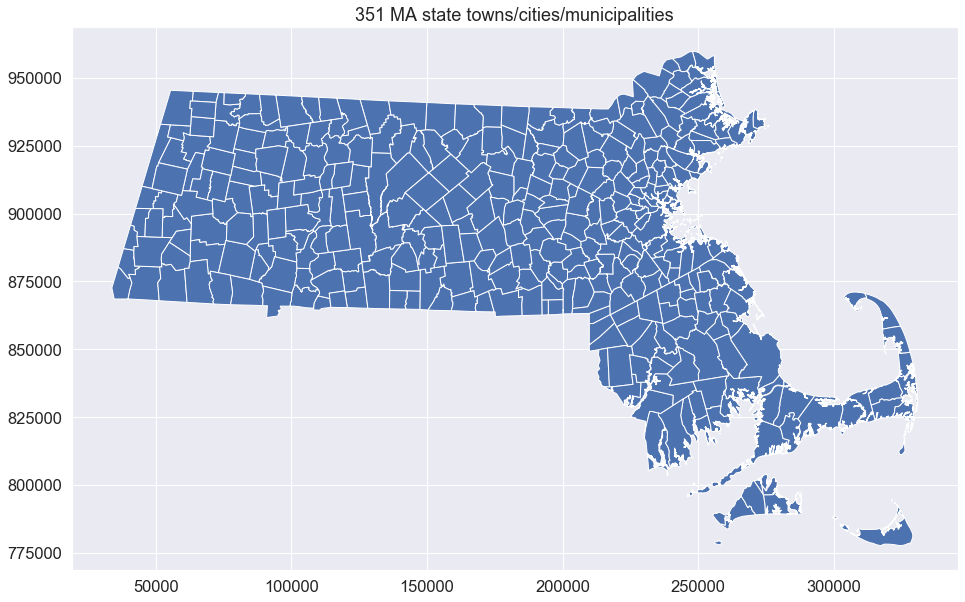

In [4]:
town_map.plot(figsize=(16,10))
plt.title("351 MA state towns/cities/municipalities")
plt.show()

In [5]:
# what's inside the shapefiles?
print(census_blocks.columns)
census_blocks.head()

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10',
       'NAMELSAD10', 'MTFCC10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'AREA_SQFT', 'AREA_ACRES', 'POP100_RE', 'HU100_RE',
       'LOGPL94171', 'LOGSF1', 'LOGACS0610', 'LOGSF1C', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,023,525104,2,250235251042,Block Group 2,G5030,2648651.0,119260.0,+41.9751132,...,683.9256,1120,404,0159334,137632,0007882,0137632,2.767760e+06,8963.749528,"POLYGON ((245073.4579000026 857943.9572999999,..."
1,25,023,525104,4,250235251044,Block Group 4,G5030,4625818.0,11563.0,+41.9677679,...,1145.8539,2178,690,0159336,137634,0007884,0137634,4.637125e+06,9555.602586,"POLYGON ((242521.254900001 859747.8350999989, ..."
2,25,023,525203,1,250235252031,Block Group 1,G5030,2367037.0,62136.0,+42.0051872,...,600.2231,1540,527,0159338,137636,0007885,0137636,2.429027e+06,9226.194871,"POLYGON ((244276.8404999971 862120.2314999998,..."
3,25,023,510100,2,250235101002,Block Group 2,G5030,686351.0,0.0,+42.1115078,...,169.5890,1172,414,0159161,137459,0007745,0137459,6.863050e+05,3338.839737,"POLYGON ((241369.4518999979 874137.570700001, ..."
4,25,023,510100,3,250235101003,Block Group 3,G5030,403906.0,0.0,+42.1115626,...,99.8001,792,290,0159162,137460,0007746,0137460,4.038783e+05,3178.436538,"POLYGON ((240747.7463999987 873189.6048000008,..."


In [6]:
print(town_map.columns)
town_map.head()

Index(['TOWN', 'TOWN_ID', 'POP1980', 'POP1990', 'POP2000', 'POPCH80_90',
       'POPCH90_00', 'TYPE', 'FOURCOLOR', 'FIPS_STCO', 'SUM_ACRES',
       'SUM_SQUARE', 'POP2010', 'POPCH00_10', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')


,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,SUM_ACRES,SUM_SQUARE,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry
0,WELLESLEY,317,26658,26615,26604,-43,-11,T,2,25021,6749.852,10.547,27982,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,NEEDHAM,199,27310,27557,28924,247,1367,T,4,25021,8130.187,12.703,28886,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,PETERSHAM,234,997,1131,1180,134,49,T,3,25027,43675.599,68.243,1234,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,READING,246,22545,22539,23708,-6,1169,T,3,25017,6393.727,9.990,24747,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,QUINCY,243,83682,84985,88025,1303,3040,C,3,25021,11080.397,17.313,92271,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,..."


In [7]:
# does this column denote state?
len(set(census_blocks['STATEFP10']))
# A: yes - all from one state

1

## Towns shapefile EDA
* do the town names match between the opioid overdose death data and the MA towns survey shapefile?
* derive the x and y coordinates of each town for modeling

In [8]:
town_map['TOWN'] = town_map['TOWN'].str.lower()
len(set(town_map['TOWN']))

351

In [9]:
print(set(town_map['TOWN']) - set(death_data['city_death']))
print(set(death_data['city_death']) - set(town_map['TOWN']))

{'north attleborough'}
{'north attleboro'}


In [10]:
# fix name
death_data['city_death'] = death_data['city_death'].replace('north attleboro', 'north attleborough')

In [11]:
town_test_merge = town_map.merge(death_data, how='left', left_on='TOWN', right_on='city_death')

In [12]:
print(len(set(town_test_merge['TOWN'])))
print(len(set(town_test_merge['city_death'])))
print(sum(town_test_merge['TOWN'] == town_test_merge['city_death']))
# able to merge without problems

351
351
351


In [13]:
town_test_merge

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry,city_death,2014,2015,2016,2017,2018
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,...",wellesley,0,1,0,0,0
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,...",needham,0,1,2,1,0
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,...",petersham,0,0,0,0,0
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344...",reading,2,2,4,4,1
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,...",quincy,39,43,36,37,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,somerville,274,75836,76210,77478,374,1268,C,4,25017,...,-1724,19884.219455,1.069865e+07,"POLYGON ((230662.7124999985 907352.6845999993,...",somerville,14,15,19,12,8
347,pembroke,231,13882,14544,16927,662,2383,T,4,25023,...,910,42341.724263,6.100547e+07,"POLYGON ((259609.4624999985 874160.1746000014,...",pembroke,3,2,5,1,0
348,duxbury,82,13174,13895,14248,721,353,T,1,25023,...,811,99884.166652,6.232911e+07,(POLYGON ((266547.2325000018 868791.5045999996...,duxbury,0,0,2,0,0
349,boxford,38,5751,6266,7921,515,1655,T,3,25009,...,44,44884.884100,6.321618e+07,"POLYGON ((233567.7524999976 943010.8845999986,...",boxford,0,0,0,0,0


In [14]:
# convert geometry to a more recognizable crs format
town_test_merge['geometry'] = town_test_merge['geometry'].to_crs(epsg=4326)
town_test_merge.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry,city_death,2014,2015,2016,2017,2018
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,1378,26738.594369,2.726958e+07,"(POLYGON ((-71.26791296846598 42.327527799305,...",wellesley,0,1,0,0,0
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,-38,28960.012825,3.294777e+07,POLYGON ((-71.22114734819833 42.30648947704145...,needham,0,1,2,1,0
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,54,73405.706629,1.767489e+08,POLYGON ((-72.10093262757198 42.48368711606084...,petersham,0,0,0,0,0
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,1039,23126.471303,2.587450e+07,POLYGON ((-71.10357918791566 42.56490520777559...,reading,2,2,4,4,1
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,4246,87188.934275,4.484078e+07,(POLYGON ((-70.98752024993465 42.3045244458064...,quincy,39,43,36,37,35


Need the town centroids for modeling - derive it here:

In [15]:
ma_town_coord = pd.DataFrame({'town':town_test_merge['TOWN'].copy(), 'x': town_test_merge.centroid.x, 'y': town_test_merge.centroid.y})
ma_town_coord.head()

,town,x,y
0,wellesley,-71.285441,42.304304
1,needham,-71.241078,42.281368
2,petersham,-72.221072,42.459687
3,reading,-71.105574,42.535054
4,quincy,-71.020353,42.250488


In [16]:
### write to csv:
#ma_town_coord.to_csv("../../data/tidy_data/ma_town_crs4326_coords.csv", index=False)

## Census block and Towns join

In [17]:
town_map.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,SUM_ACRES,SUM_SQUARE,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,6749.852,10.547,27982,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,needham,199,27310,27557,28924,247,1367,T,4,25021,8130.187,12.703,28886,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,petersham,234,997,1131,1180,134,49,T,3,25027,43675.599,68.243,1234,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,6393.727,9.990,24747,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,11080.397,17.313,92271,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,..."


### Joining the geometries directly: 

In [18]:
# how does the intersects option do?
intersects_join = gpd.sjoin(town_map, census_blocks, how='left', op='intersects')

In [19]:
# original number of towns:
print(town_map.shape)
# number of towns in the intersects join:
print(len(set(intersects_join['TOWN'])))
print(census_blocks.shape)
print(intersects_join.shape)
print(len(set(intersects_join['GEOID10'])))
intersects_join['GEOID10'].value_counts()

(351, 17)
351
(4979, 22)
(8697, 39)
4979


250110401004    10
250158227003     9
250110406003     9
250277231003     8
250138130004     8
                ..
250010101004     1
250138016021     1
250092082003     1
250251803014     1
250173107002     1
Name: GEOID10, Length: 4979, dtype: int64

In [20]:
# how does the within option do?
within_join = gpd.sjoin(town_map, census_blocks, how='left', op='within')
# original number of towns:
print(town_map.shape)
# number of towns in the within join:
print(len(set(within_join['TOWN'])))
print(census_blocks.shape)
print(within_join.shape)
print(len(set(within_join['GEOID10'])))
within_join['GEOID10'].value_counts()

(351, 17)
351
(4979, 22)
(351, 39)
1


Series([], Name: GEOID10, dtype: int64)

In [21]:
# how does the contains option do?
within_join = gpd.sjoin(town_map, census_blocks, how='left', op='contains')
# original number of towns:
print(town_map.shape)
# number of towns in the contains join:
print(len(set(contains_join['TOWN'])))
print(census_blocks.shape)
print(contains_join.shape)
print(len(set(contains_join['GEOID10'])))
contains_join['GEOID10'].value_counts()

(351, 17)


NameError: name 'contains_join' is not defined

### Notes:
* intersects - assigns census blocks to too many towns
* within - terrible
* contains - too many census blocks lost

### Alternative geometry joining strategy: 
* convert the geometry of the census blocks to points (centroids) - join using contains (no need to worry about borders and geometry overlap) 
* check how well this join works by comparing 2010 population totals by town

In [ ]:
centroid_blocks = census_blocks.copy()
# change geometry 
centroid_blocks['geometry'] = centroid_blocks['geometry'].centroid
centroid_blocks.head()

In [ ]:
centroid_blocks.plot(figsize=(16,10))
plt.title("2010 Census Block Tract Centroids (MA State)")
plt.show()

In [ ]:
points = census_blocks.copy()
# change geometry 
points['geometry'] = points['geometry'].centroid
points.head()
points.plot()
cent_join = gpd.sjoin(test_merge, points, how='left', op='contains')
cent_join.head()
cent_join.shape
census_blocks.shape
cent_join.head()
cent_join_sub = cent_join[['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10', 'SHAPE_AREA', 'POP100_RE']].copy()
cent_join_sub.head()
cent_join_block_sum = cent_join_sub.groupby('TOWN').sum()[['POP100_RE']].reset_index()
cent_join_block_sum.head()
cent_join_block_sum.shape
cent_join_sum_to_exp = cent_join_sub[['TOWN', 'POP2010']].drop_duplicates().merge(cent_join_block_sum, on='TOWN', how='inner')

In [ ]:
display(cent_join_sum_to_exp.head())
sns.regplot(x='POP2010', y='POP100_RE', data=cent_join_sum_to_exp)

In [ ]:
cent_join_sum_to_exp['error'] = (abs(cent_join_sum_to_exp['POP100_RE'] - cent_join_sum_to_exp['POP2010']) * 100) / cent_join_sum_to_exp['POP2010']
cent_join_sum_to_exp.head()
cent_join_sum_to_exp.sort_values('error', ascending=False)
cent_join_sum_to_exp['error'].hist(bins=100)
cent_join_sum_to_exp[cent_join_sum_to_exp['error'] > 20].shape
cent_join_sum_to_exp[cent_join_sum_to_exp['error'] > 20]
cent_join_sub.head()
#cent_join_sub.to_csv("../")

In [ ]:
test5 = gpd.sjoin(test_merge, census_blocks, how='left', op='contains')
test5.shape
test5.head()
test5.plot(cmap=None)